In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

# <a id='1'>1.Data</a>

In [2]:
telcom = pd.read_csv("telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
#first few rows
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## <a id='1.1'>1.1. Data overview</a>

In [3]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


# <a id='2'>2. Data Manipulation</a>

In [4]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

# <a id='3'>3. Exploratory Data Analysis</a>

## <a id='3.1'>3.1. Customer attrition in data</a>

In [5]:
#labels
lab = telcom["Churn"].value_counts().keys().tolist()
#values
val = telcom["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig,filename='graph', image='png')

## <a id='3.2'>3.2. Varibles distribution in customer attrition</a>

In [19]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 15),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(telcom)

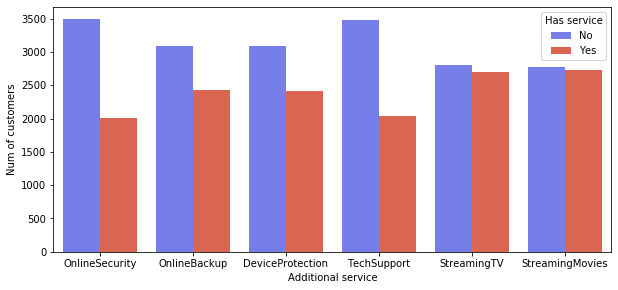

In [7]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(telcom[telcom["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x='variable', hue='Has service',palette=["#636EFA","#EF553B"])
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

## <a id='3.6'>3.6. Monthly charges,total charges and tenure in customer attrition</a>

# <a id='4'>4. Data preprocessing</a>

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")


In [13]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## <a id='3.7'>3.7. Variable Summary</a>

In [6]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Summary Statistics"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure,filename='variable', image='png')


## <a id='3.8'>3.8. Correlation Matrix</a>

In [7]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 620,
                        width   = 700,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='correlation', image='png')

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    print(coef_sumry)
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients")



    coefficients                                 features
0      -0.091316                                   gender
1       0.214301                            SeniorCitizen
2       0.001045                                  Partner
3      -0.132834                               Dependents
4      -0.480695                             PhoneService
5      -0.456957                           OnlineSecurity
6      -0.219041                             OnlineBackup
7      -0.038238                         DeviceProtection
8      -0.341462                              TechSupport
9       0.121634                              StreamingTV
10      0.198980                          StreamingMovies
11      0.365649                         PaperlessBilling
12     -0.413296                         MultipleLines_No
13     -0.135652           MultipleLines_No phone service
14     -0.067399                        MultipleLines_Yes
15     -0.251331                      InternetService_DSL
16      0.3047

C:\Users\Pravesh Bisaria\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## <a id='5.3'>5.3. Recursive Feature Elimination</a>

In [33]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit,10)
rfe = rfe.fit(train_X,train_Y)

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in telcom.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = train_X[cols]
train_rf_Y = train_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
telecom_churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients")

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

   coefficients                     features
0     -0.495160               OnlineSecurity
1      0.475826              StreamingMovies
2     -0.491706             MultipleLines_No
3      1.082227  InternetService_Fiber optic
4     -0.859093           InternetService_No
5      0.790180      Contract_Month-to-month
6     -0.896060            Contract_Two year
7      0.868854    tenure_group_Tenure_48-60
8      0.890714    tenure_group_Tenure_gt_60
9     -1.170343                       tenure
LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1268
           1       0.66      0.49      0.57       490

    accuracy                           0.79      1758
   macro avg       0.74      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758

Accuracy   Score :  0.7895335608646189
Area under curve :  0.6988315199896993 



C:\Users\Pravesh Bisaria\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

